## % - to - Weights

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  


def calculate_wrr_weights(data_link_rate, percentage_times, average_packet_sizes):
    weights = []

    # Calculate weights for each queue
    for time, size in zip(percentage_times, average_packet_sizes):
        weight =  (time/100)*(data_link_rate/8) / size
        # print(weight)
        weights.append(weight)

    # Normalize weights
    total_weight = sum(weights)
    normalized_weights = [weight / total_weight for weight in weights]

    return normalized_weights

# Example parameters
data_link_rate = 39e9  # Gbps
# DL - 18.99 ; 20
percentage_times = [25.64,23.07,51.28]  # Percentages for Queue 1, Queue 2, Queue 3
# average_packet_sizes = [972.13, 92, 269]  # Average packet sizes for Queue 1, Queue 2, Queue 3
average_packet_sizes = [160,1358,1450]  # Average packet sizes for Queue 1, Queue 2, Queue 3

# Calculate WRR weights
wrr_weights = calculate_wrr_weights(data_link_rate, percentage_times, average_packet_sizes)
print("WRR Weights:", np.multiply(wrr_weights,100))


WRR Weights: [75.37496923  7.9905548  16.63447597]


In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  


def calculate_wrr_weights(data_link_rate, percentage_times, normalized_packets ,average_packet_sizes):
    weights = []
    packet_scale = []
    # Calculate weights for each queue
    for time, size in zip(percentage_times, average_packet_sizes):
        weight =  (time/100)*(data_link_rate/8) / size
        # print(weight)
        weights.append(weight)

    # Normalize weights
    
    for w, p in zip(weights, normalized_packets):
        weight =  w*p
        # print(weight)
        packet_scale.append(weight)
   
    total_weight = sum(packet_scale)
    normalized_weights = [weight / total_weight for weight in packet_scale]

    return normalized_weights

# Example parameters
data_link_rate = 39e9  # Gbps
percentage_times = [66,28,6]  # Percentages for Queue 1, Queue 2, Queue 3
average_packet_sizes = [972.13, 92, 269]  # Average packet sizes for Queue 1, Queue 2, Queue 3
# average_packet_sizes = [283, 92, 269]  # Average packet sizes for Queue 1, Queue 2, Queue 3
Q_packets = [1/packet for packet in average_packet_sizes]
sumpackets = sum(Q_packets)
normalized_packets = [Q/ sumpackets for Q in Q_packets]
print(f"Q_weights: {np.multiply(normalized_packets,100)}" )
# Calculate WRR weights
wrr_weights = calculate_wrr_weights(data_link_rate, percentage_times, normalized_packets ,average_packet_sizes)
print("WRR Weights:", np.multiply(wrr_weights,100))


Q_weights: [19.50027972 59.98455611 20.51516417]
WRR Weights: [ 9.37851477 88.74242314  1.87906209]


##  Weights - to - %

In [4]:
res = []
wrr_weights = [20, 75, 5]
average_packet_sizes = [255, 92, 269]  # Average packet sizes for Queue 1, Queue 2, Queue 3
for value_1, value_2 in zip(wrr_weights, average_packet_sizes):
    print(value_1*value_2*100)
    res.append(value_1*value_2*100)
res = res/np.sum(res)    
print(res)

510000
690000
134500
[0.38216561 0.51704758 0.10078681]


# Adjusting middle link capacity

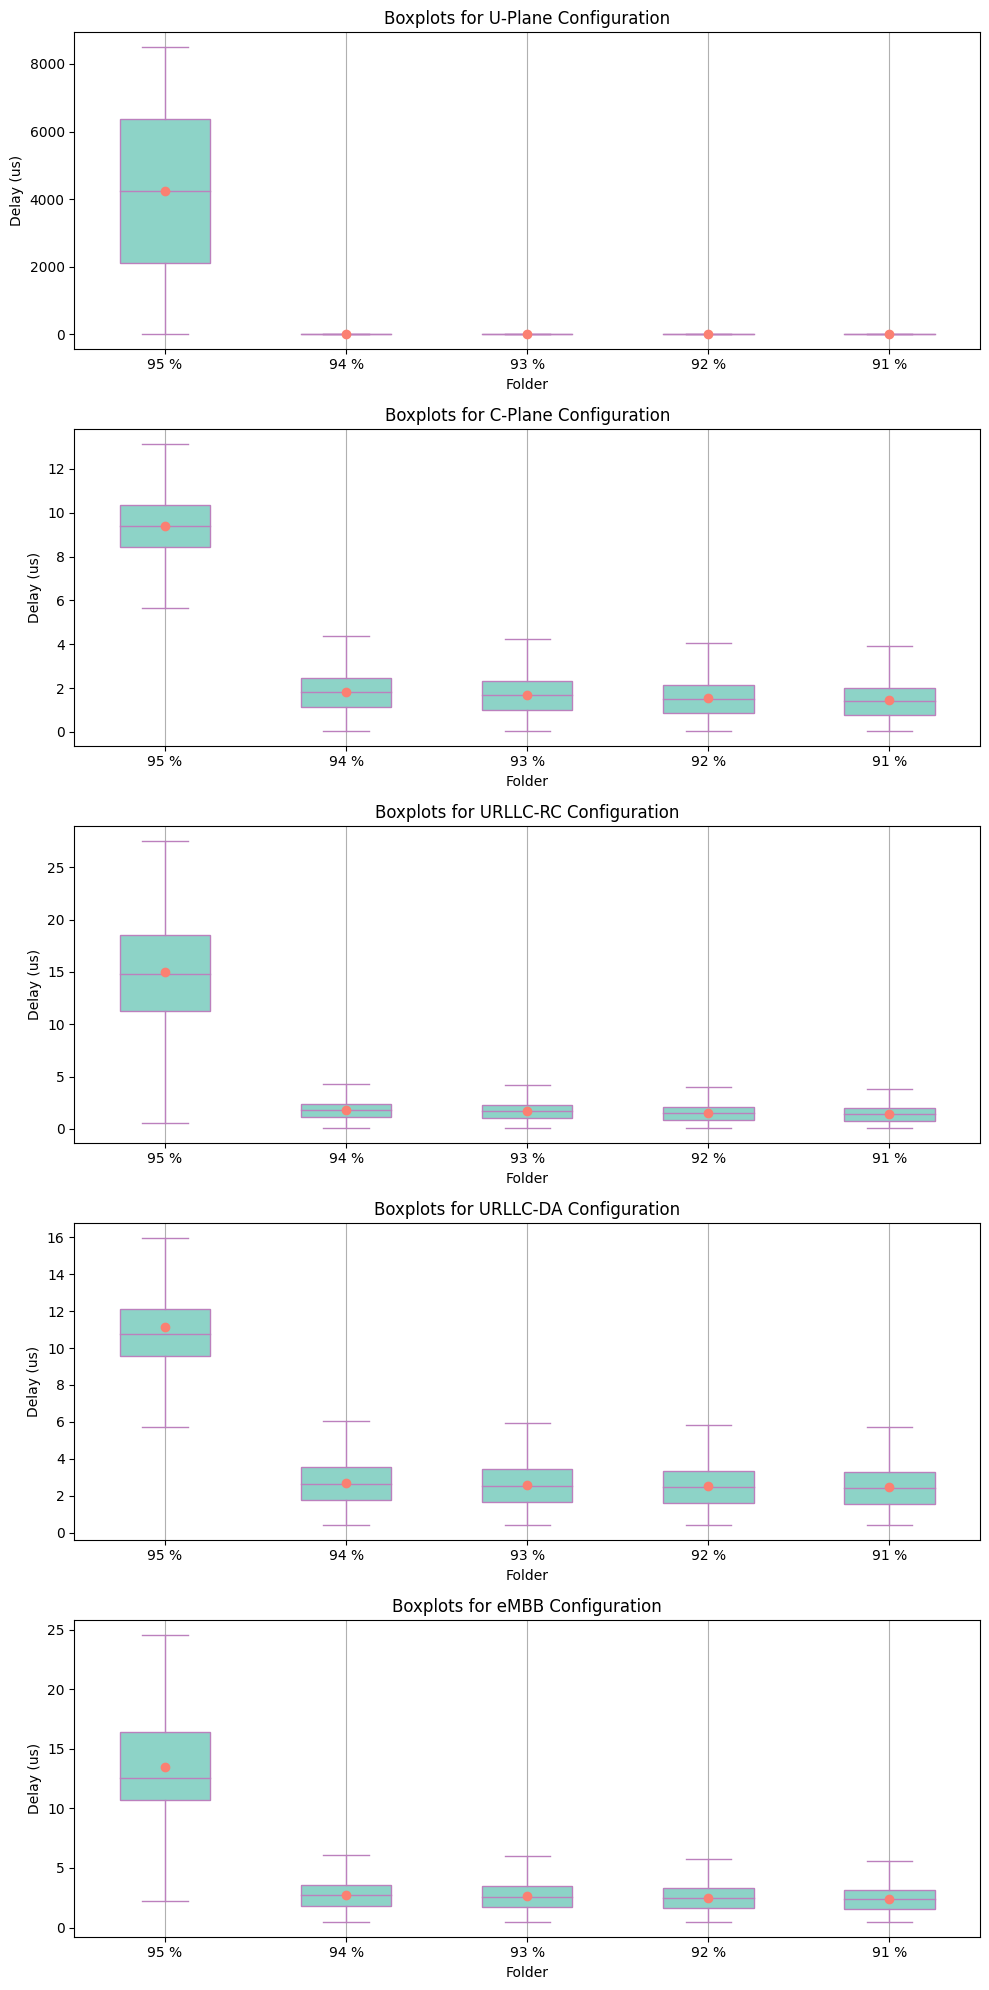

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  

# Set a custom color palette
colors = plt.cm.Set3.colors

plt.rcParams["figure.autolayout"] = True

Flow_min_value = 1
Flow_max_value = 4
RU = 3
Step = 1
configs_txt = ["U-Plane", "C-Plane", "URLLC-RC", "URLLC-DA", "eMBB"]
Flows = np.arange(1, Flow_max_value + Step, Step)
Ru = np.arange(1, RU + Step, Step)
AAUs = np.arange(1, 13, 1)
Nsim = 1

def process_folder(folder):
    delay = []
    delay_aux = [] 
    delay_us = []
    delay_control = []
    delay_user = []
    delay_rt = []

    for flow in Flows:
        if flow == 1:
            for ru in Ru:
                CTx = pd.read_csv(f"{folder}TxFileControl{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                UTx = pd.read_csv(f"{folder}TxFileUser{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                CRx = pd.read_csv(f"{folder}RxFileControl{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                URx = pd.read_csv(f"{folder}RxFileUser{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])

                min_len = min(len(UTx), len(URx))
                delay_user.append(URx["Time"].values[:min_len-1] - UTx["Time"].values[:min_len-1])
                min_len = min(len(CTx), len(CRx))
                delay_control.append(CRx["Time"].values[:min_len-1] - CTx["Time"].values[:min_len-1])

            delay.append(np.concatenate(delay_user))
            delay.append(np.concatenate(delay_control))
        else: 
            delay_rt = []
            for num in AAUs:
                Tx = pd.read_csv(f"{folder}TxFile{num-1 + 12*(flow-2)}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                Rx = pd.read_csv(f"{folder}RxFile{num-1 + 12*(flow-2)}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                min_len = min(len(Tx), len(Rx))
                delay_rt.append( Rx["Time"].values[:(min_len-1)] - Tx["Time"].values[:(min_len-1)])

            delay.append(np.concatenate(delay_rt))

    delay_us = [arr*1e-9 for arr in delay]    
    return delay_us

# folders = ["./sim_results/Flow20M_39/", "./sim_results/Flow20M_40/", "./sim_results/Flow20M_41/", "./sim_results/Flow20M_42/", "./sim_results/Flow20M_43/", "./sim_results/Flow20M_44/"]

# Define parameters
Start = 55.26
Stop = 59.3
Step = 1
Cap_swept = np.arange(Start, Stop, Step, dtype=float)  # Convert to integer
Type_of_combis = ["Nonsched_DL3_CU-plane"]
folders = [f"./sim_results/{name_combi}_20M_{cap:.2f}/" for name_combi in Type_of_combis for cap in Cap_swept]


# Process data for each folder
delay_us_dict = {}
for folder in folders:
    delay_us_dict[folder] = process_folder(folder)


# Plot all boxplots in the same figure
fig, axes = plt.subplots(nrows=len(configs_txt), ncols=1, figsize=(10, 20))

for i, config in enumerate(configs_txt):
    ax = axes[i]
    # Collect delay data for this configuration label from all folders
   
    data = [delay_us_dict[folder][i] for folder in folders]
    # Plot boxplots for this configuration label
    bp = ax.boxplot(
        data,
        labels=[f"{95-1*(j)} %" for j in range(len(folders))],
        showmeans=True,
        showfliers=False,
        patch_artist=True,  # fill with color
        boxprops=dict(facecolor=colors[0], color=colors[9]),
        capprops=dict(color=colors[9]),
        whiskerprops=dict(color=colors[9]),
        flierprops=dict(markeredgecolor=colors[9], markerfacecolor=colors[9]),
        medianprops=dict(color=colors[9]),
        meanprops=dict(marker="o", markerfacecolor=colors[3], markeredgecolor=colors[3]),
    )
    ax.set_title(f"Boxplots for {config} Configuration")
    
    ax.set_ylabel("Delay (us)")
    ax.set_xlabel("Folder")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.grid()

    # Extracting boxplot information
    lw = [item.get_ydata()[1] for item in bp['whiskers'][::2]]
    lq = [item.get_ydata()[0] for item in bp['whiskers'][::2]]
    med = [item.get_ydata()[1] for item in bp['medians']]
    uq = [item.get_ydata()[0] for item in bp['whiskers'][1::2]]
    uw = [item.get_ydata()[1] for item in bp['whiskers'][1::2]]
    xaux = range(len(folders))
    avg = [item.get_ydata()[0] for item in bp['means']]

    # Write to a text file
    with open(f"./sim_results/boxplot_coordinates_{config.replace(' ', '_')}.txt", "w") as f:
        f.write("lw\tlq\tmed\tuq\tuw\txaux\tavg\n")
        for lw_val, lq_val, med_val, uq_val, uw_val, xaux_val, avg_val in zip(lw, lq, med, uq, uw, xaux, avg):
            f.write(f"{lw_val}\t{lq_val}\t{med_val}\t{uq_val}\t{uw_val}\t{xaux_val}\t{avg_val}\n")

plt.tight_layout()
plt.show()


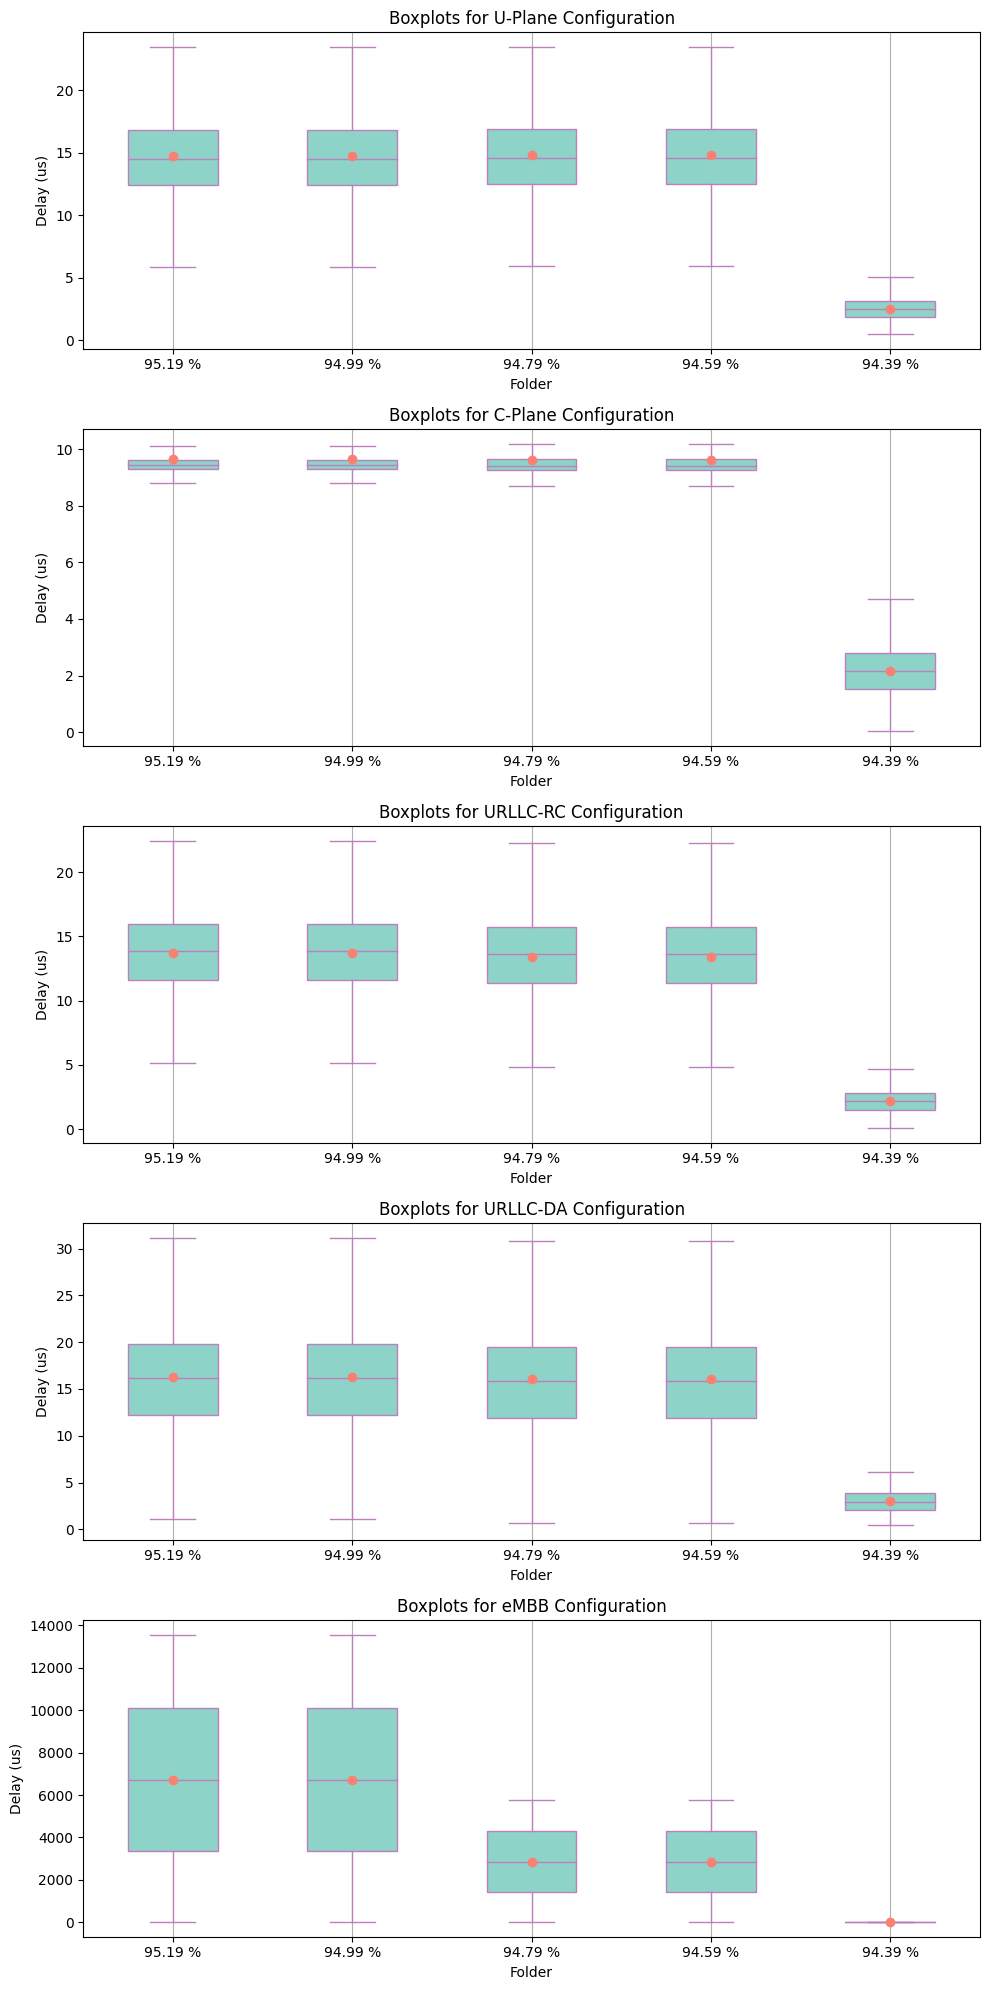

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  

# Set a custom color palette
colors = plt.cm.Set3.colors

plt.rcParams["figure.autolayout"] = True


# Define parameters
agregado = 52.49
Start = 55.14
Stop = 55.3
Step = 0.04
Cap_swept = np.arange(Start, Stop+(Step/2), Step, dtype=float)  
Type_of_combis = ["MOD_DL_UPandLowSep_CU-plane"]
folders = [f"./sim_results/{name_combi}_20M_{cap:.2f}/" for name_combi in Type_of_combis for cap in Cap_swept]







Flow_min_value = 1
Flow_max_value = 4
RU = 3
Step = 1
configs_txt = ["U-Plane", "C-Plane", "URLLC-RC", "URLLC-DA", "eMBB"]
Flows = np.arange(1, Flow_max_value + Step, Step)
Ru = np.arange(1, RU + Step, Step)
AAUs = np.arange(1, 13, 1)
Nsim = 1

def process_folder(folder):
    delay = []
    delay_aux = [] 
    delay_us = []
    delay_control = []
    delay_user = []
    delay_rt = []

    for flow in Flows:
        if flow == 1:
            for ru in Ru:
                CTx = pd.read_csv(f"{folder}TxFileControl{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                UTx = pd.read_csv(f"{folder}TxFileUser{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                CRx = pd.read_csv(f"{folder}RxFileControl{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                URx = pd.read_csv(f"{folder}RxFileUser{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])

                min_len = min(len(UTx), len(URx))
                delay_user.append(URx["Time"].values[:min_len] - UTx["Time"].values[:min_len])
                min_len = min(len(CTx), len(CRx))
                delay_control.append(CRx["Time"].values[:min_len] - CTx["Time"].values[:min_len])

            delay.append(np.concatenate(delay_user))
            delay.append(np.concatenate(delay_control))
        else: 
            delay_rt = []
            for num in AAUs:
                Tx = pd.read_csv(f"{folder}TxFile{num-1 + 12*(flow-2)}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                Rx = pd.read_csv(f"{folder}RxFile{num-1 + 12*(flow-2)}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                min_len = min(len(Tx), len(Rx))
                delay_rt.append( Rx["Time"].values[:(min_len-1)] - Tx["Time"].values[:(min_len-1)])

            delay.append(np.concatenate(delay_rt))

    delay_us = [arr*1e-9 for arr in delay]    
    return delay_us






# Process data for each folder
delay_us_dict = {}
for folder in folders:
    delay_us_dict[folder] = process_folder(folder)


# Plot all boxplots in the same figure
fig, axes = plt.subplots(nrows=len(configs_txt), ncols=1, figsize=(10, 20))

for i, config in enumerate(configs_txt):
    ax = axes[i]
    # Collect delay data for this configuration label from all folders
   
    data = [delay_us_dict[folder][i] for folder in folders]
    # Plot boxplots for this configuration label
    bp = ax.boxplot(
        data,
        labels=[f"{((agregado/Start)*100)-0.2*(j):.2f} %" for j in range(len(folders))],
        showmeans=True,
        showfliers=False,
        patch_artist=True,  # fill with color
        boxprops=dict(facecolor=colors[0], color=colors[9]),
        capprops=dict(color=colors[9]),
        whiskerprops=dict(color=colors[9]),
        flierprops=dict(markeredgecolor=colors[9], markerfacecolor=colors[9]),
        medianprops=dict(color=colors[9]),
        meanprops=dict(marker="o", markerfacecolor=colors[3], markeredgecolor=colors[3]),
    )
    ax.set_title(f"Boxplots for {config} Configuration")
    
    ax.set_ylabel("Delay (us)")
    ax.set_xlabel("Folder")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.grid()

    # Extracting boxplot information
    lw = [item.get_ydata()[1] for item in bp['whiskers'][::2]]
    lq = [item.get_ydata()[0] for item in bp['whiskers'][::2]]
    med = [item.get_ydata()[1] for item in bp['medians']]
    uq = [item.get_ydata()[0] for item in bp['whiskers'][1::2]]
    uw = [item.get_ydata()[1] for item in bp['whiskers'][1::2]]
    xaux = range(len(folders))
    avg = [item.get_ydata()[0] for item in bp['means']]

    # Write to a text file
    with open(f"./sim_results/boxplot_coordinates_{config.replace(' ', '_')}.txt", "w") as f:
        f.write("lw\tlq\tmed\tuq\tuw\txaux\tavg\n")
        for lw_val, lq_val, med_val, uq_val, uw_val, xaux_val, avg_val in zip(lw, lq, med, uq, uw, xaux, avg):
            f.write(f"{lw_val}\t{lq_val}\t{med_val}\t{uq_val}\t{uw_val}\t{xaux_val}\t{avg_val}\n")

plt.tight_layout()
plt.show()


# Extract coordinates from boxplot 

In [69]:
# Extracting boxplot information
boxplot_info = {
    "lw": [item.get_ydata()[1] for item in bp['whiskers'][::2]],
    "lq": [item.get_ydata()[0] for item in bp['whiskers'][::2]],
    "med": [item.get_ydata()[1] for item in bp['medians']],
    "uq": [item.get_ydata()[0] for item in bp['whiskers'][1::2]],
    "uw": [item.get_ydata()[1] for item in bp['whiskers'][1::2]],
    "xaux": range(len(configs_txt)),
    "avg": [item.get_ydata()[0] for item in bp['means']]
}

# Write boxplot information to a text file
with open(folder + "boxplot_info.txt", "w") as file:
    file.write("lw\tlq\tmed\tuq\tuw\txaux\tavg\n")
    for i in range(len(configs_txt)):
        line = "\t".join(str(boxplot_info[key][i]) for key in boxplot_info.keys())
        file.write(line + "\n")

if (delay_us[1] == 0).any():
    print(True)

# Checking - boxplots weight distribution

1
2
3


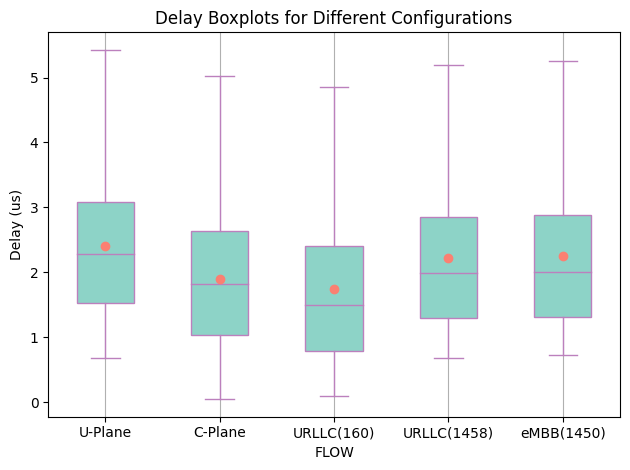

Mean Delay for U-Plane: 2.4011280776381767 us
Mean Delay for C-Plane: 1.9041140228603293 us
Mean Delay for URLLC(160): 1.7402046494722718 us
Mean Delay for URLLC(1458): 2.2255591021903567 us
Mean Delay for eMBB(1450): 2.2516820177281134 us
Overall Mean Delay: 2.10453757397785 us
Flow U-Plane Jitter = 1.14 us
Flow C-Plane Jitter = 1.17 us
Flow URLLC(160) Jitter = 1.28 us
Flow URLLC(1458) Jitter = 1.24 us
Flow eMBB(1450) Jitter = 1.25 us


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  

# Set a custom color palette
colors = plt.cm.Set3.colors

folder = "./sim_results/Prueba/"
plt.rcParams["figure.autolayout"] = True

numAAU = 12
Flows = 4
RU = 3
Step = 1

configs_txt = ["U-Plane", "C-Plane", "URLLC(160)", "URLLC(1458)", "eMBB(1450)"]
# configs_txt = ["URLLC(160)", "URLLC(1458)", "eMBB(1450)"]
Flows = np.arange(1, Flows + Step, Step)
Ru = np.arange(1, RU + Step, Step)
AAUs = np.arange(1, numAAU+1, 1)
Nsim = 1
delay = []
delay_aux = [] 
fmt=["bo", "go", "yo"]
delay_us = []
delay_control = []
delay_user = []
delay_rt = []
for flow in Flows:
    # Read data into pandas DataFrames
    if flow == 1:
        for ru in Ru:
            print(ru)
            CTx = pd.read_csv(f"{folder}TxFileControl{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            UTx = pd.read_csv(f"{folder}TxFileUser{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            CRx = pd.read_csv(f"{folder}RxFileControl{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            URx = pd.read_csv(f"{folder}RxFileUser{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])

            # Calculate delay for user and control configurations
            min_len = min(len(UTx), len(URx))
            delay_user.append(URx["Time"].values[:min_len-1] - UTx["Time"].values[:min_len-1])
            min_len = min(len(CTx), len(CRx))
            delay_control.append(CRx["Time"].values[:min_len-1] - CTx["Time"].values[:min_len-1])
            # Assign values to the corresponding columns in the delay DataFrame
            
        delay.append(np.concatenate(delay_user))
        delay.append(np.concatenate(delay_control))
        # print("Nothing")
    else: 
        delay_rt = []
        for num in AAUs:
            # print(f"Num AAU flow{num}")
            Tx = pd.read_csv(f"{folder}TxFile{num-1 + numAAU*(flow-2)}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            Rx = pd.read_csv(f"{folder}RxFile{num-1 + numAAU*(flow-2)}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            # Ensure that the length of 'Tx' matches the length of 'Rx'
            min_len = min(len(Tx), len(Rx))
            delay_rt.append( Rx["Time"].values[:(min_len-1)] - Tx["Time"].values[:(min_len-1)])

        # Assign values to the corresponding columns in the delay DataFrame
        delay.append(np.concatenate(delay_rt))
    
# print("All done")
# Boxplot with enhanced style
delay_us = [arr*1e-9 for arr in delay]    
delay = []
bp = plt.boxplot(
    delay_us,
    labels=configs_txt,
    showmeans=True,
    showfliers=False,
    patch_artist=True,  # fill with color
    boxprops=dict(facecolor=colors[0], color=colors[9]),
    capprops=dict(color=colors[9]),
    whiskerprops=dict(color=colors[9]),
    flierprops=dict(markeredgecolor=colors[9], markerfacecolor=colors[9]),
    medianprops=dict(color=colors[9]),
    meanprops=dict(marker="o", markerfacecolor=colors[3], markeredgecolor=colors[3]),
)

# Customize labels and title
plt.ylabel("Delay (us)")
plt.xlabel("FLOW")
plt.title("Delay Boxplots for Different Configurations")

# Add gridlines
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.grid()
plt.show()

# Extracting mean delay values from the boxplot object
mean_delays = [item.get_ydata()[0] for item in bp['means']]

# Printing mean delay for each configuration
for config, mean_delay in zip(configs_txt, mean_delays):
    print(f"Mean Delay for {config}: {mean_delay} us")


print(f"Overall Mean Delay: {np.mean(mean_delays)} us")
jitter = []
jitter = [np.std(flow_jitter) for flow_jitter in delay_us]
for flow, flow_jitter in zip(configs_txt, jitter):
    print(f"Flow {flow} Jitter = {flow_jitter:.2f} us")

flow
0    19.680039
1    75.038186
2     5.281775
dtype: float64


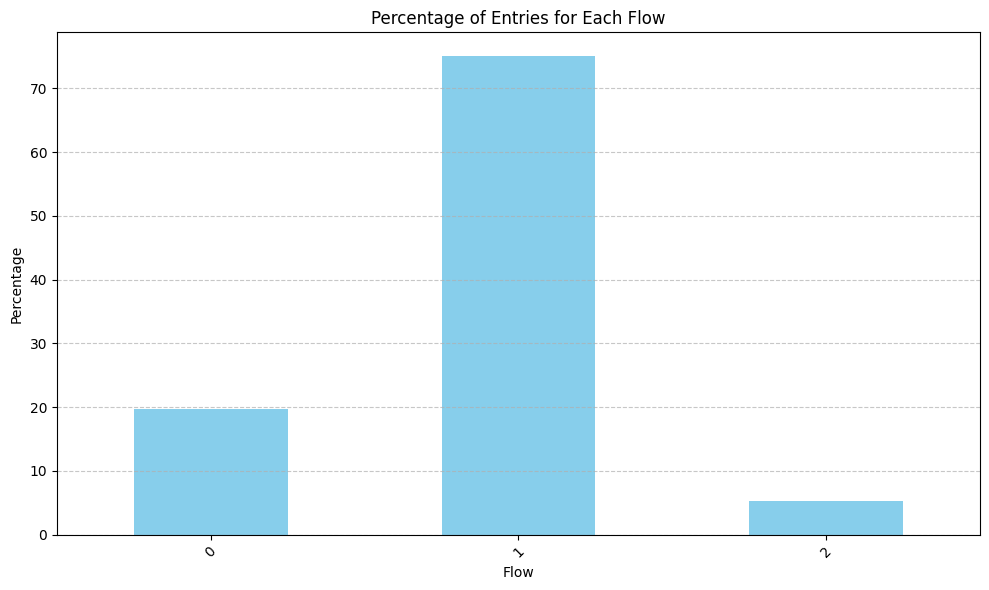

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
folder = "./sim_results/"
Sched_dec = pd.read_csv(f"{folder}sched-wdrr-decision.log", sep='\s+', header=None, names=["flow", "pktsize"])
# Count the number of entries with flow equal to a specific number
flow_count = Sched_dec.groupby('flow').size()
# print(flow_count)

# Calculate the percentage of entries for each flow
percentage = (flow_count / flow_count.sum()) * 100
print(percentage)
# Plotting
plt.figure(figsize=(10, 6))
percentage.plot(kind='bar', color='skyblue')
plt.title('Percentage of Entries for Each Flow')
plt.xlabel('Flow')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


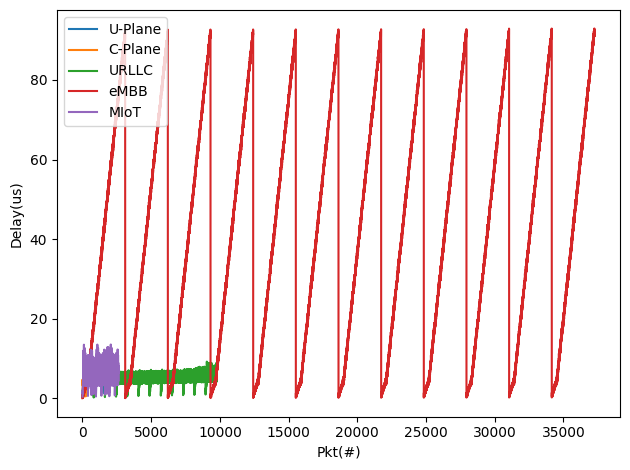

In [4]:
plt.plot(delay_us[0], label="U-Plane")
plt.plot(delay_us[1], label="C-Plane")
plt.plot(delay_us[2], label="URLLC")
plt.plot(delay_us[3], label="eMBB")
plt.plot(delay_us[4], label="MIoT")
plt.ylabel("Delay(us)")
plt.xlabel("Pkt(#)")
plt.legend()

All done


ValueError: Dimensions of labels and X must be compatible

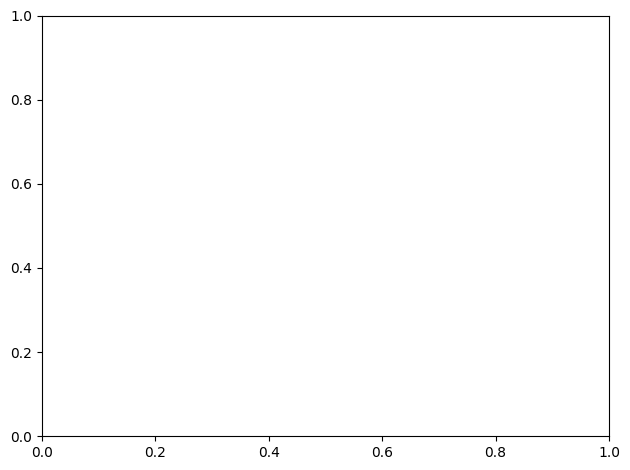

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  

# Set a custom color palette
colors = plt.cm.Set3.colors

folder = "./sim_results/Prueba/"
plt.rcParams["figure.autolayout"] = True

Flow_min_value = 1
Flow_max_value = 1
RU = 1
Step = 1
configs_txt = ["U-Plane", "C-Plane", "URLLC", "eMBB", "MIoT"]
Flows = np.arange(1, Flow_max_value + Step, Step)
Ru = np.arange(1, RU + Step, Step)
AAUs = np.arange(1, 13, 1)
Nsim = 1
thput = []
delay_aux = [] 
fmt=["bo", "go", "yo"]
delay = []
delay_us = []
delay_control = []
delay_user = []
delay_rt = []
for flow in Flows:
    # Read data into pandas DataFrames
    if flow == 1:
        for ru in Ru:            
            CRx = pd.read_csv(f"{folder}RxFileControl{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            URx = pd.read_csv(f"{folder}RxFileUser{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])

            # Calculate delay for user and control configurations
            min_len = len(URx)
            delay_user.append(URx["Value"].sum()*8/((URx["Time"].values[min_len-1] - URx["Time"].values[0])))
            min_len = len(CRx)
            delay_control.append(CRx["Value"].sum()*8/((CRx["Time"].values[min_len-1] - CRx["Time"].values[0])))
            # Assign values to the corresponding columns in the delay DataFrame
            
        delay.append(delay_user)
        delay.append(delay_control)
    else: 
        delay_rt = []
        for num in AAUs:
            # print(f"Num AAU flow{num}")
            # Tx = pd.read_csv(f"{folder}TxFile{num-1 + 12*(flow-2)}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            Rx = pd.read_csv(f"{folder}RxFile{num-1 + 12*(flow-2)}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            # Ensure that the length of 'Tx' matches the length of 'Rx'
            min_len = len(Rx)
            delay_rt.append( Rx["Value"].sum()*8/((Rx["Time"].values[min_len-1] - Rx["Time"].values[0])))

        # Assign values to the corresponding columns in the delay DataFrame
        delay.append((delay_rt))
    
print("All done")
# Boxplot with enhanced style

bp = plt.boxplot(
    delay,
    labels=configs_txt,
    showmeans=True,
    showfliers=False,
    patch_artist=True,  # fill with color
    boxprops=dict(facecolor=colors[0], color=colors[9]),
    capprops=dict(color=colors[9]),
    whiskerprops=dict(color=colors[9]),
    flierprops=dict(markeredgecolor=colors[9], markerfacecolor=colors[9]),
    medianprops=dict(color=colors[9]),
    meanprops=dict(marker="o", markerfacecolor=colors[3], markeredgecolor=colors[3]),
)

# Customize labels and title
plt.ylabel("Thput (Gbps)")
plt.xlabel("FLOW")
plt.title("Thput - CU-Plane PRIO")

# Add gridlines
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.grid()
plt.show()